### Урок3. Связь бизнес-показателей и DS-метрик

План занятия:
0. Ликбез: train/test/val и crossvalidation
1. переход от вероятностей к меткам в задаче бинарной классификации
2. какие бывают DS-метрики, их интерпретация
3. пример из практики
4. бизнес-метрики
5. взаимосвязь DS и бизнес метрик
6. case1 - фильтрация токсичных комментариев
7. case2 - определение ССЗ 

F-score достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.

In [82]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [81]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

Разделим наши данные на тренировочную и тестовую выборки

In [34]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [84]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [85]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [90]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [125]:
def get_model_scores(y_test, y_score):
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_test, y_score)
    return precision[ix], recall[ix], fscore[ix], roc_auc

In [126]:

precision_lr, recall_lr, fscore_lr ,roc_auc_lr = \
    get_model_scores(y_test, y_score)


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

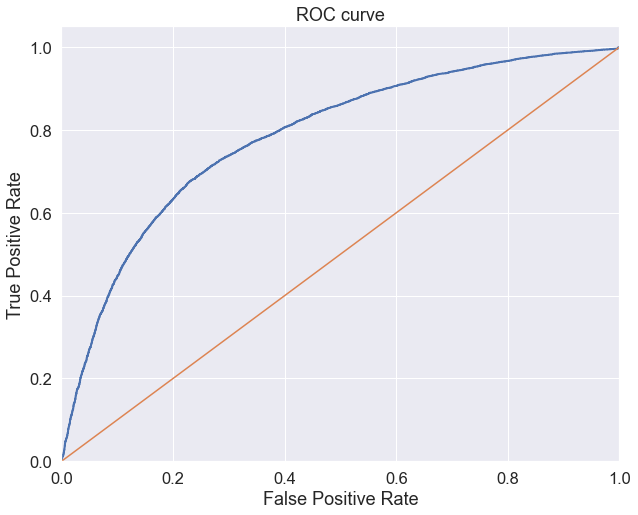

In [93]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [94]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230667


In [95]:
from catboost import CatBoostClassifier

In [96]:
classifier_cb = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(iterations=200,\
                                     max_depth=3, silent = True,\
                                     eval_metric = 'F1',\
                                     #early_stopping_rounds = 20,\
                                     reg_lambda=2,\
                                    random_state = 42))])


#запустим кросс-валидацию
cv_scores_cb = cross_val_score(classifier_cb, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_cb = np.mean(cv_scores_cb)
cv_score_std_cb = np.std(cv_scores_cb)
print('CV score is {}+-{}'.format(cv_score_cb, cv_score_std_cb))

#обучим пайплайн на всем тренировочном датасете
classifier_cb.fit(X_train, y_train)
y_score_cb = classifier_cb.predict_proba(X_test)[:, 1]

CV score is 0.7999341316780266+-0.007156932544850484


Посчитаем precision/recall/f_score

In [127]:
precision_cb, recall_cb, fscore_cb, roc_auc_cb = get_model_scores(y_test, y_score_cb)


In [120]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
classifier_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators= 200,\
                                          random_state = 42,\
                                          bootstrap= True,\
                                         oob_score = True)),
])


#запустим кросс-валидацию
cv_scores_rf = cross_val_score(classifier_rf, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_rf = np.mean(cv_scores_rf)
cv_score_std_rf = np.std(cv_scores_rf)
print('CV score is {}+-{}'.format(cv_score_rf, cv_score_std_rf))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.7750962717651989+-0.007743179907655178


In [128]:
precision_rf, recall_rf, fscore_rf, roc_auc_rf = get_model_scores(y_test, y_score_rf)

In [129]:
d={'Model': ['Logistic Regression','Catboost','Random Forest'],\
   'F-Score': [fscore_lr, fscore_cb, fscore_rf],\
   'Precision': [precision_lr, precision_cb, precision_rf],\
   'Recall':[recall_lr, recall_cb, recall_rf],\
   'Roc-Auc':[roc_auc_lr, roc_auc_cb,roc_auc_rf]}
df = pd.DataFrame(data=d)
df

,Model,F-Score,Precision,Recall,Roc-Auc
0,Logistic Regression,0.730323,0.647431,0.837558,0.784035
1,Catboost,0.740256,0.697322,0.788825,0.800259
2,Random Forest,0.720847,0.658288,0.796544,0.772236


Если сравнивать полученные метрики у разных моделей - 
видно, что в целом, модель Catboost дает метрики лучше, кроме recall.
Если в приоритете полнота - то самой лучшей можно считать LR модель

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Рассмотрим модель 1:

In [106]:
n = 100000

In [107]:
TP_1 = 90
FP_1 = 10
FN_1 = 10
TN_1 = 99890

In [112]:
precision_1 = TP_1/(TP_1+FP_1)
recall_1 = precision_1 = TP_1/(TP_1+FN_1)
precision_1, recall_1

(0.9, 0.9)

In [113]:
TPR_1 = recall_1

In [115]:
FPR_1 = FP_1/(FP_1+TN_1)
TPR_1, FPR_1

(0.9, 0.0001001001001001001)

In [ ]:
Рассмотрим модель 2:

In [108]:
TP_2 = 90
FP_2 = 910
FN_2 = 10
TN_2 = n -TP_2 -FP_2-FN_2

In [116]:
precision_2 = TP_2/(TP_2+FP_2)
recall_2 = TP_2/(TP_2+FN_2)
precision_2, recall_2

(0.09, 0.9)

In [117]:
TPR_2 = recall_2
FPR_2 = FP_2/(FP_2+TN_2)
TPR_2, FPR_2

(0.9, 0.00910910910910911)

Видим, что если мы смотрим на параметры presicion и recall - очевидно, модель номер 1 - лучше (точность намного выше при одинаковой полноте).
При этом - если мы смотрим на TPR и FPR - кажется, что модель 2 дает результат лучше. Из чего сделаем вывод:

В случае большого дисбаланса классов лучше подходит метрика precision_recall_curve

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic